

# Objetivo

En este trabajo vamos a analizar los datos epidemiológicos generados por el grupo de trabajo [#escovid19data](https://github.com/montera34/escovid19data). Siguiendo los procesos estándares descargaremos los datos desde gitub, analizaremos los campos y prepararemos una serie de gráficas como ayuda para entender como estñá progresando la enfermedad.


@author: Manuel H. Arias 

@Twitter: @walyt

@mail: mharias@me.com



## Importación de librerias estándares para DAE

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.colors as colors

import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
%matplotlib inline

import urllib.request

import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import itertools

## Descargamos la información

Hacemos en primer lugar una actualización de parámetros y preparación de variables que necesitaremos durante el ejercicio

In [2]:
pd.options.display.max_rows = 999 #Variable de contexto para permitir la presentación de datos por pantalla
pd.set_option('display.max_columns', None)

In [3]:
#fuente de pdatos
data_path = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Datos_Capacidad_Asistencial_Historico_30032021.csv'
img_path = '/Users/mharias/documents/proyectos/covid/sanidad_hospital/img/'
autor='@walyt'
escovid='@escovid19data'

In [4]:
hashtag_fuente='#escovid19data' #hashtag de la fuente para los créditos

In [5]:
hoy_string = datetime.today().strftime(format='%d %b')

In [6]:
hoy_string

'31 Mar'

Leemos los datos en un `pandas`

In [40]:
df = pd.read_csv(data_path,encoding = "ISO-8859-1",sep=';')

veamos una rápida descripción de la información:

In [41]:
df.head()

,Fecha,Unidad,COD_CCAA,CCAA,Cod_Provincia,Provincia,TOTAL_CAMAS,OCUPADAS_COVID19,OCUPADAS_NO_COVID19
0,2020-08-19,Hospitalización convencional,8,CASTILLA LA MANCHA,2,Albacete,895,25,531
1,2020-08-19,U. Críticas CON respirador,5,ISLAS CANARIAS,35,"Palmas, Las",213,10,87
2,2020-08-19,U. Críticas CON respirador,10,COMUNIDAD VALENCIANA,12,Castellón/Castelló,69,2,28
3,2020-08-19,U. Críticas SIN respirador,1,ANDALUCÍA,23,Jaén,65,4,6
4,2020-08-19,U. Críticas SIN respirador,7,CASTILLA Y LEÓN,9,Burgos,4,0,2


veamos las  columnas de interés:

In [42]:
df.columns

Index(['Fecha', 'Unidad', 'COD_CCAA', 'CCAA', 'Cod_Provincia', 'Provincia',
       'TOTAL_CAMAS', 'OCUPADAS_COVID19', 'OCUPADAS_NO_COVID19'],
      dtype='object')

In [43]:
df.Unidad.unique()

array(['Hospitalización convencional', 'U. Críticas CON respirador',
       'U. Críticas SIN respirador'], dtype=object)

In [44]:
df.CCAA.unique()

array(['CASTILLA LA MANCHA', 'ISLAS CANARIAS', 'COMUNIDAD VALENCIANA',
       'ANDALUCÍA', 'CASTILLA Y LEÓN', 'MELILLA', 'CATALUÑA', 'CANTABRIA',
       'EXTREMADURA', 'ARAGÓN', 'GALICIA', 'NAVARRA', 'PAÍS VASCO',
       'MURCIA', 'CEUTA', 'MADRID', 'LA RIOJA', 'ISLAS BALEARES',
       'ASTURIAS'], dtype=object)

Parece que es ok, no hay nombres duplicados (muy usual que cambie algún acento por ejemplo)

Convertimos la columna `fecha` en datetime

In [45]:
df['Fecha'] = pd.to_datetime(df['Fecha'],format='%Y-%m-%d')

y vamos añadir dos columnas adicionales `hola` : 
- `porcentaje_total`:  `OCUPADAS_COVID19`+`OCUPADAS_NO_COVID19` / `TOTAL_CAMAS` 
- `porcentaje_covid`: `OCUPADAS_COVID19`/ `TOTAL_CAMAS`

In [93]:
(df['Provincia']=='Madrid').any()

True

In [46]:
provincias = sorted(list(df['Provincia'].unique()))
provincias.insert(0,provincias.pop(-1))

In [136]:
fechas = df['Fecha'].unique()
unidades = df['Unidad'].unique()
for i in itertools.product(fechas,provincias,unidades):
    if ((df['Fecha']==i[0])&(df['Provincia']==i[1])&(df['Unidad']==i[2])).any():
        pass
    else:
        print (i)
        df=df.append({
            'Fecha':i[0],
            'Provincia':i[1],
            'Unidad':i[2],
            'TOTAL_CAMAS':np.NaN,
            'OCUPADAS_COVID19':np.NaN,
            'OCUPADAS_COVID19':np.NaN
        },
            ignore_index=True
        )

(numpy.datetime64('2020-12-08T00:00:00.000000000'), 'Palencia', 'Hospitalización convencional')
(numpy.datetime64('2020-12-08T00:00:00.000000000'), 'Palencia', 'U. Críticas CON respirador')
(numpy.datetime64('2020-12-08T00:00:00.000000000'), 'Palencia', 'U. Críticas SIN respirador')
(numpy.datetime64('2021-01-02T00:00:00.000000000'), 'Palencia', 'Hospitalización convencional')
(numpy.datetime64('2021-01-02T00:00:00.000000000'), 'Palencia', 'U. Críticas CON respirador')
(numpy.datetime64('2021-01-02T00:00:00.000000000'), 'Palencia', 'U. Críticas SIN respirador')
(numpy.datetime64('2021-01-03T00:00:00.000000000'), 'Ceuta', 'Hospitalización convencional')
(numpy.datetime64('2021-01-03T00:00:00.000000000'), 'Ceuta', 'U. Críticas CON respirador')
(numpy.datetime64('2021-01-03T00:00:00.000000000'), 'Ceuta', 'U. Críticas SIN respirador')


In [137]:
df.tail()

,Fecha,Unidad,COD_CCAA,CCAA,Cod_Provincia,Provincia,TOTAL_CAMAS,OCUPADAS_COVID19,OCUPADAS_NO_COVID19,porcentaje_total,porcentaje_covid
34783,2021-01-02,U. Críticas CON respirador,NaN,NaN,NaN,Palencia,NaN,NaN,NaN,NaN,NaN
34784,2021-01-02,U. Críticas SIN respirador,NaN,NaN,NaN,Palencia,NaN,NaN,NaN,NaN,NaN
34785,2021-01-03,Hospitalización convencional,NaN,NaN,NaN,Ceuta,NaN,NaN,NaN,NaN,NaN
34786,2021-01-03,U. Críticas CON respirador,NaN,NaN,NaN,Ceuta,NaN,NaN,NaN,NaN,NaN
34787,2021-01-03,U. Críticas SIN respirador,NaN,NaN,NaN,Ceuta,NaN,NaN,NaN,NaN,NaN


In [134]:
df[df['Provincia']=='Palencia'].sort_values('Fecha')

,Fecha,Unidad,COD_CCAA,CCAA,Cod_Provincia,Provincia,TOTAL_CAMAS,OCUPADAS_COVID19,OCUPADAS_NO_COVID19,porcentaje_total,porcentaje_covid
128,2020-08-19,U. Críticas CON respirador,7,CASTILLA Y LEÓN,34,Palencia,14.0,0.0,12,85.714286,0.000000
1157,2020-08-19,U. Críticas SIN respirador,7,CASTILLA Y LEÓN,34,Palencia,0.0,0.0,0,0.000000,0.000000
1153,2020-08-19,Hospitalización convencional,7,CASTILLA Y LEÓN,34,Palencia,331.0,6.0,252,77.945619,1.812689
842,2020-08-20,Hospitalización convencional,7,CASTILLA Y LEÓN,34,Palencia,329.0,5.0,263,81.458967,1.519757
652,2020-08-20,U. Críticas SIN respirador,7,CASTILLA Y LEÓN,34,Palencia,0.0,0.0,0,0.000000,0.000000
970,2020-08-20,U. Críticas CON respirador,7,CASTILLA Y LEÓN,34,Palencia,14.0,0.0,11,78.571429,0.000000
1228,2020-08-21,U. Críticas CON respirador,7,CASTILLA Y LEÓN,34,Palencia,14.0,0.0,10,71.428571,0.000000
1109,2020-08-21,U. Críticas SIN respirador,7,CASTILLA Y LEÓN,34,Palencia,0.0,0.0,0,0.000000,0.000000
975,2020-08-21,Hospitalización convencional,7,CASTILLA Y LEÓN,34,Palencia,329.0,4.0,238,73.556231,1.215805
88,2020-08-22,Hospitalización convencional,7,CASTILLA Y LEÓN,34,Palencia,329.0,4.0,238,73.556231,1.215805


In [138]:
df['porcentaje_total'] = 100*(df['OCUPADAS_COVID19']+df['OCUPADAS_NO_COVID19'])/df['TOTAL_CAMAS']
df['porcentaje_covid'] = 100*(df['OCUPADAS_COVID19'])/df['TOTAL_CAMAS']

In [141]:
df=df.fillna(0)

# Gráficos

 A continuación vamos a crear un gráfico múltiple que nos permita visualizar cada una de las columnas con datos numéricos. Ello nos permitirá

Preparemos un gráfico tipo [Facetgrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html), al que añadiremos tantos gráficos como provincias, presentando una de las columnas de datos. Elegimos nº de hospitalizados por 100.000 habitantes. Dejo otras claves con `#` para que fácilmente se puedan generar. Este ejemplo esta basado en el código del link anterior.

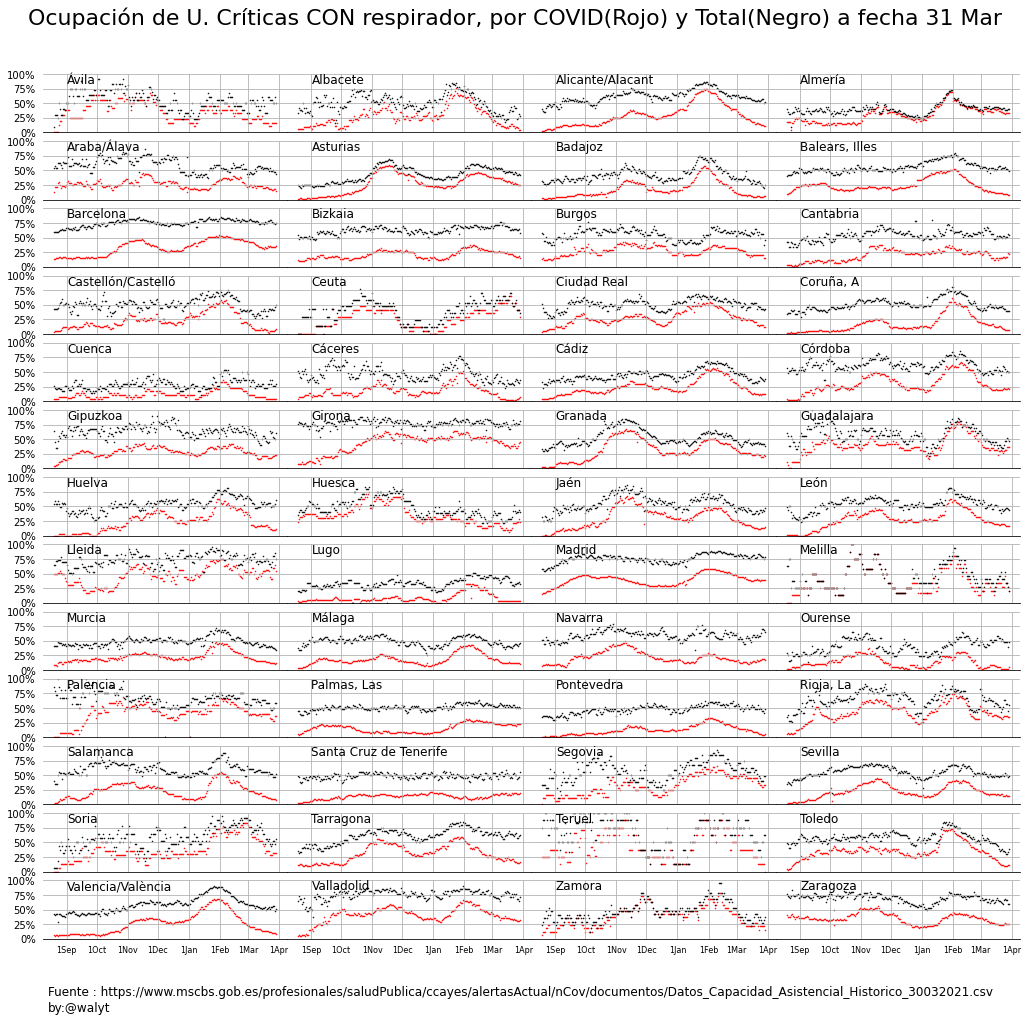

In [197]:
# Creamos la figura desde Matplotlib
#plt.figure()

# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(52, rot=-.25, light=.7)

datos = df.copy()

sns.plotting_context('paper', font_scale = 1.3)
g = sns.FacetGrid(datos,col='Provincia',hue='Provincia',col_wrap=4,aspect=3, 
                      margin_titles=False,height=1.2,sharey=True,col_order=provincias)

# Título
unidad = 'Hospitalización convencional'
unidad = 'U. Críticas CON respirador'
#unidad = 'U. Críticas SIN respirador'
titulo1 = 'Ocupación de {}, por COVID(Rojo) y Total(Negro) a fecha {}'.format(unidad,hoy_string)
titulo2 = 'Fuente : {}'.format(data_path)
color_ejes = 'black'
color_titulos = 'black'
color_total='black'
color_covid='red'

#g.fig.text(1, 0,'Fuente: {}'.format(hashtag_fuente), fontsize=10,horizontalalignment='right') #add text
#g.fig.text(1,0.01,'Código:{}'.format(github_url),
          # fontsize=10,horizontalalignment='right')
# Draw the densities in a few steps

XmajorFmt = DateFormatter('%-d%-b')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = ticker.FormatStrFormatter(fmt)
def grafica(x, color, label):
    ax1 = plt.gca()
    #ax1.xaxis_date()
    try:
        datos_ = datos[(datos['Provincia'] == label) & (datos['Unidad']==unidad)].sort_values('Fecha')
    except:
        pass
     
    
    #datos_ = datos[(datos['Provincia'] == label) & (datos['Unidad']=='U. Críticas CON respirador')].sort_values('Fecha')
        
    #ax1.fill_between(datos['date'].unique(), datos[AI],color=color_diarios)
    ax1.text(0.1, .9, label, weight='normal',color=color_ejes,
            ha="left", va="center", size=12,transform=ax1.transAxes)
    ax1.set_ylim(0,100)
    ax1.set_yticks([0,25,50,75,100])
    
    ax1.yaxis.set_major_formatter(yticks)
    
    ax1.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
    #ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
    ax1.xaxis.set_major_formatter(XmajorFmt)
    ax1.xaxis.set_major_locator(DayLocator([1]))
    #ax1.set_xticks([])
    ax1.grid(True,axis='both',which='both')
    #sns.lineplot(data=datos_,x='Fecha',y='porcentaje_covid',hue='Unidad',ax=ax1,ci=None,legend=False)
    
    ax1.scatter(
        datos_['Fecha'],
        datos_['porcentaje_covid'],
        s=.3,
        color=color_covid)
                   
    ax1.scatter(
        datos_['Fecha'],
        datos_['porcentaje_total'],
        s=.3,
        color=color_total
    )
    
    
    #ax2.legend()
    
g.map(grafica,'Provincia')

#plt.legend()
g.set_titles("")
#g.set(yticks=[])
g.set(xlabel='')

g.despine(bottom=False, left=True)
g.fig.suptitle('{}'.format(titulo1),fontsize=22,color=color_titulos)
#g.fig.text(x=.4,y=.05,s='ROJO: CAMAS UCI COVID vs UCI TOTALES',color='red',fontsize=18)
#g.fig.text(x=.4,y=.1,s='AZUL: CAMAS HOSP COVID vs CAMAS TOTALES',color='navy',fontsize=18)
g.fig.text(x=0.05,y=.1,s=titulo2,color=color_titulos,fontsize=12,ha='left')
g.fig.text(x=0.05,y=.085,s='by:'+autor,color=color_titulos,fontsize=12)
g.fig.subplots_adjust(top=.92,bottom=.1,wspace=0.0,hspace=0.15)
#plt.tight_layout()
plt.savefig(img_path+unidad+'_provincias.png',dpi=288)  

plt.show()


# Graficos de UCI acumulados con respirador y sin respirador

In [156]:
datos2 = df.copy()

In [157]:
for i in itertools.product(fechas,provincias):
    
    
    
    camas_sin = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas SIN respirador')]['TOTAL_CAMAS'].values[0]
    camas_con = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas CON respirador')]['TOTAL_CAMAS'].values[0]
    ocupadas_covid_sin = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas SIN respirador')]['OCUPADAS_COVID19'].values[0]
    ocupadas_covid_con = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas CON respirador')]['OCUPADAS_COVID19'].values[0]
    ocupadas_no_covid_sin = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas SIN respirador')]['OCUPADAS_NO_COVID19'].values[0]
    ocupadas_no_covid_con = datos2.loc[(datos2['Fecha']==i[0])&(datos2['Provincia']==i[1])&(datos2['Unidad']==\
                                                'U. Críticas CON respirador')]['OCUPADAS_NO_COVID19'].values[0]
    datos2=datos2.append({
        'Fecha':i[0],
        'Provincia':i[1],
        'TOTAL_CAMAS':camas_sin+camas_con,
        'OCUPADAS_NO_COVID19':ocupadas_no_covid_sin+ocupadas_no_covid_con,
        'OCUPADAS_COVID19':ocupadas_covid_sin+ocupadas_covid_con,
        'Unidad':'U. Crítica Total'
        
    },ignore_index=True)

In [176]:
datos2['porcentaje_total'] = 100*(datos2['OCUPADAS_COVID19']+datos2['OCUPADAS_NO_COVID19'])/datos2['TOTAL_CAMAS']
datos2['porcentaje_covid'] = 100*datos2['OCUPADAS_COVID19']/datos2['TOTAL_CAMAS']
datos2=datos2.fillna(0)

In [180]:
datos3 = datos2[~datos2['Unidad'].isin(['U. Críticas CON respirador','U. Críticas SIN respirador'])]

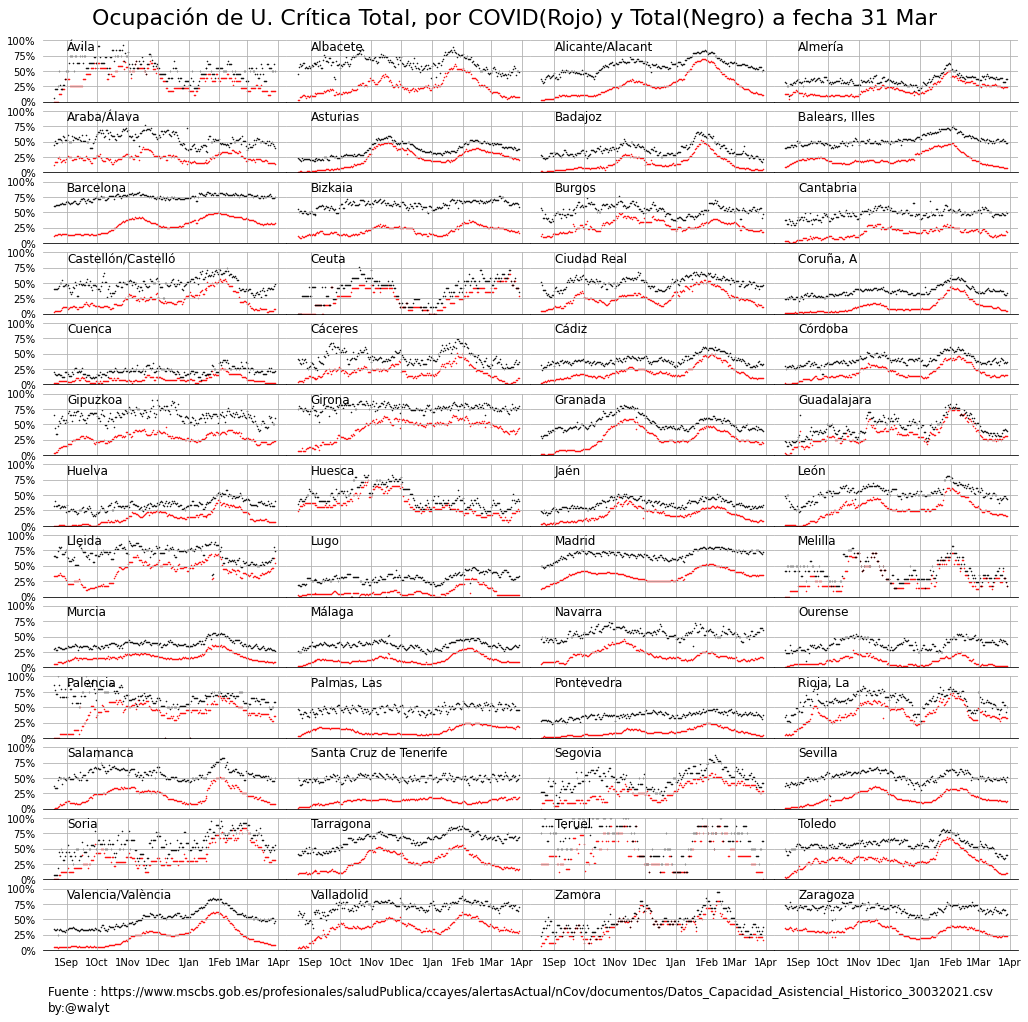

In [203]:
# Creamos la figura desde Matplotlib
#plt.figure()

# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(52, rot=-.25, light=.7)

#datos = df.copy()

sns.plotting_context('paper', font_scale = 1.3)
g = sns.FacetGrid(datos3,col='Provincia',hue='Provincia',col_wrap=4,aspect=3, 
                      margin_titles=False,height=1.2,sharey=True,col_order=provincias)

unidad = 'U. Crítica Total'
titulo1 = 'Ocupación de {}, por COVID(Rojo) y Total(Negro) a fecha {}'.format(unidad,hoy_string)
titulo2 = 'Fuente : {}'.format(data_path)
color_ejes = 'black'
color_titulos = 'black'
color_total='black'
color_covid='red'

#g.fig.text(1, 0,'Fuente: {}'.format(hashtag_fuente), fontsize=10,horizontalalignment='right') #add text
#g.fig.text(1,0.01,'Código:{}'.format(github_url),
          # fontsize=10,horizontalalignment='right')
# Draw the densities in a few steps

XmajorFmt = DateFormatter('%-d%-b')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = ticker.FormatStrFormatter(fmt)
def grafica(x, color, label):
    ax1 = plt.gca()
    #ax1.xaxis_date()
    
    datos_ = datos3[(datos3['Provincia'] == label) & (datos3['Unidad']==unidad)].sort_values('Fecha')
    
    #datos_ = datos[(datos['Provincia'] == label) & (datos['Unidad']=='U. Críticas CON respirador')].sort_values('Fecha')
        
    #ax1.fill_between(datos['date'].unique(), datos[AI],color=color_diarios)
    ax1.text(0.1, .9, label, weight='normal',color=color_ejes,
            ha="left", va="center", size=12,transform=ax1.transAxes)
    ax1.set_ylim(0,100)
    ax1.set_yticks([0,25,50,75,100])
    
    ax1.yaxis.set_major_formatter(yticks)
    
    ax1.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
    #ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax1.xaxis.set_major_formatter(XmajorFmt)
    ax1.xaxis.set_major_locator(DayLocator([1]))
    #ax1.set_xticks([])
    ax1.grid(True,axis='both',which='both')
    #sns.lineplot(data=datos_,x='Fecha',y='porcentaje_covid',hue='Unidad',ax=ax1,ci=None,legend=False)
    
    ax1.scatter(
        datos_['Fecha'],
        datos_['porcentaje_covid'],
        s=.3,
        color=color_covid)
                   
    ax1.scatter(
        datos_['Fecha'],
        datos_['porcentaje_total'],
        s=.3,
        color=color_total
    )
    
    
    #ax2.legend()
    
g.map(grafica,'Provincia')

#plt.legend()
g.set_titles("")
#g.set(yticks=[])
g.set(xlabel='')

g.despine(bottom=False, left=True)
g.fig.suptitle('{}'.format(titulo1),fontsize=22,color=color_titulos)
#g.fig.text(x=.4,y=.05,s='ROJO: CAMAS UCI COVID vs UCI TOTALES',color='red',fontsize=18)
#g.fig.text(x=.4,y=.1,s='AZUL: CAMAS HOSP COVID vs CAMAS TOTALES',color='navy',fontsize=18)
g.fig.text(x=0.05,y=.1,s=titulo2,color=color_titulos,fontsize=12,ha='left')
g.fig.text(x=0.05,y=.085,s='by:'+autor,color=color_titulos,fontsize=12)
g.fig.subplots_adjust(top=.95,bottom=.14,wspace=0.0,hspace=0.15)
#plt.tight_layout()
plt.savefig(img_path+unidad+'_provincias.png',dpi=288)  

plt.show()
